# Dynamic Price Optimization


**Objective**

The goal of this project is to optimize the pricing strategy for retail products to maximize profits. We use historical sales data to:

- Forecast demand for products using advanced machine learning (XGBoost).
- Optimize prices using Linear Programming while considering competitor prices and cost constraints.
- Provide actionable insights and visualizations via a dashboard for real-time decision-making.


## 0. Setup

We start by importing the necessary libraries for data handling, visualization, machine learning, and optimization.

In [1]:
#!pip install kagglehub
#!pip install xgboost
#!pip install pulp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.optimize import minimize
from pulp import LpProblem, LpVariable, LpMaximize, lpSum, value
import kagglehub
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split


## 1. Data Preparation and Exploration


### 1.1: Load and Clean the Data


- Loading the dataset containing product sales, pricing, and competitor information.
- Converting date fields to a proper format.
- Removing outliers to ensure data consistency.

In [2]:
# Step 1: Load Dataset
# Download dataset from Kaggle
path = kagglehub.dataset_download("aswathrao/demand-forecasting")
print("Path to dataset files:", path)

# Load train, test, and sample submission datasets
train_data = pd.read_csv(f"{path}/train_0irEZ2H.csv")
test_data = pd.read_csv(f"{path}/test_nfaJ3J5.csv")

Path to dataset files: C:\Users\asira\.cache\kagglehub\datasets\aswathrao\demand-forecasting\versions\1


In [3]:
# Check for missing values
print(train_data.isnull().sum())
train_data.dropna(inplace=True)
print(train_data.isnull().sum())

record_ID          0
week               0
store_id           0
sku_id             0
total_price        1
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64
record_ID          0
week               0
store_id           0
sku_id             0
total_price        0
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64


In [4]:
print(train_data.dtypes)

record_ID            int64
week                object
store_id             int64
sku_id               int64
total_price        float64
base_price         float64
is_featured_sku      int64
is_display_sku       int64
units_sold           int64
dtype: object


In [5]:
# Convert week column to datetime
train_data['week'] = pd.to_datetime(train_data['week'], format='%y/%m/%d')

* train_data['total_price'] * 0.05: The random values are scaled by total_price and a factor of 0.05, which means the competitor price will vary by ±5% of the total_price. This introduces variability but keeps the overall price dependence.

In [6]:
# Add competitor pricing (synthetic generation)
def generate_competitor_pricing(data, margin=0.1):
    data['competitor_price'] = data['base_price'] * np.random.uniform(1 - margin, 1 + margin, len(data))
    return data

train_data = generate_competitor_pricing(train_data)

## 2. Exploratory Data Analysis (EDA)


In [7]:
print(train_data.head())
print(train_data.info())
print(train_data.describe())

   record_ID       week  store_id  sku_id  total_price  base_price  \
0          1 2017-01-11      8091  216418      99.0375    111.8625   
1          2 2017-01-11      8091  216419      99.0375     99.0375   
2          3 2017-01-11      8091  216425     133.9500    133.9500   
3          4 2017-01-11      8091  216233     133.9500    133.9500   
4          5 2017-01-11      8091  217390     141.0750    141.0750   

   is_featured_sku  is_display_sku  units_sold  competitor_price  
0                0               0          20        112.256913  
1                0               0          28        107.566026  
2                0               0          19        146.202998  
3                0               0          44        124.354634  
4                0               0          52        137.293288  
<class 'pandas.core.frame.DataFrame'>
Index: 150149 entries, 0 to 150149
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------     

### 2.1: Visualize the Data

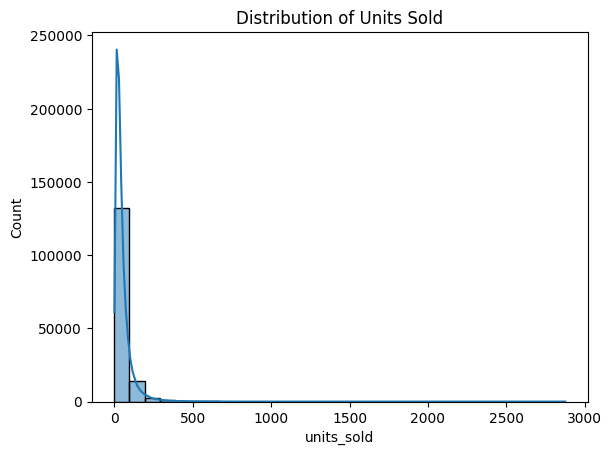

In [8]:
# Distribution of target variable (units sold)
sns.histplot(train_data['units_sold'], kde=True, bins=30)
plt.title("Distribution of Units Sold")
plt.show()

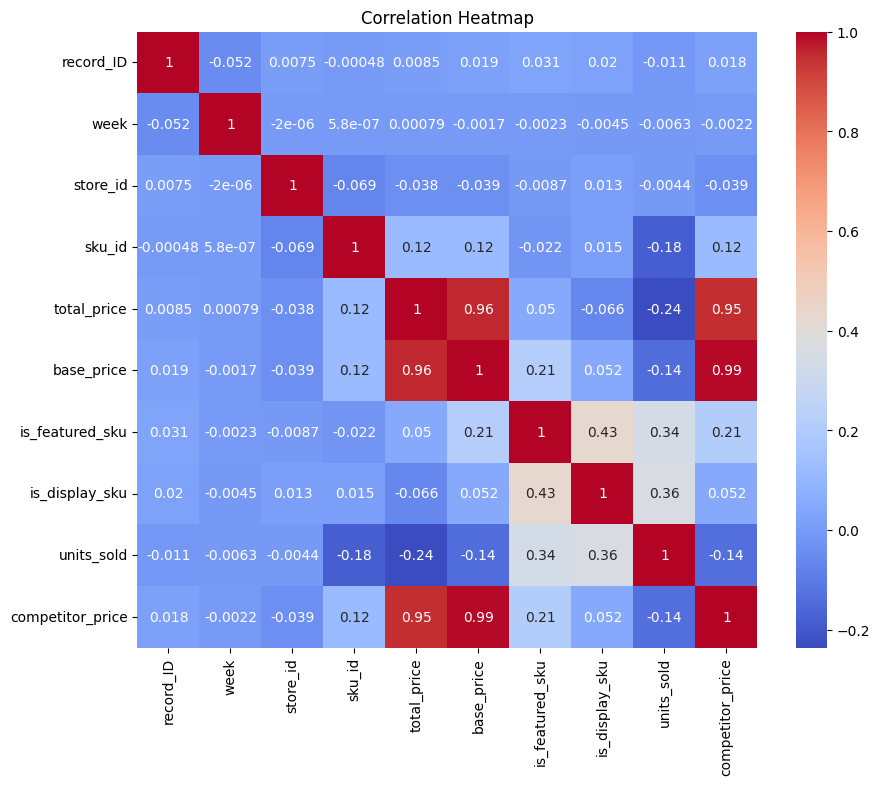

In [9]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(train_data.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

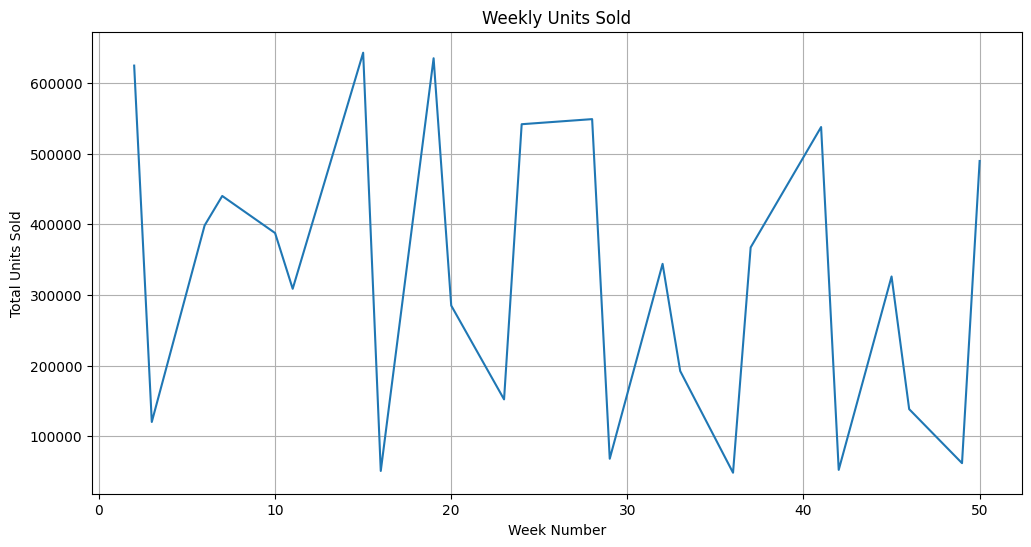

In [10]:
# Time series analysis of total units sold per week
train_data['week_num'] = train_data['week'].dt.isocalendar().week
weekly_sales = train_data.groupby('week_num')['units_sold'].sum()
plt.figure(figsize=(12, 6))
weekly_sales.plot()
plt.title("Weekly Units Sold")
plt.xlabel("Week Number")
plt.ylabel("Total Units Sold")
plt.grid()
plt.show()

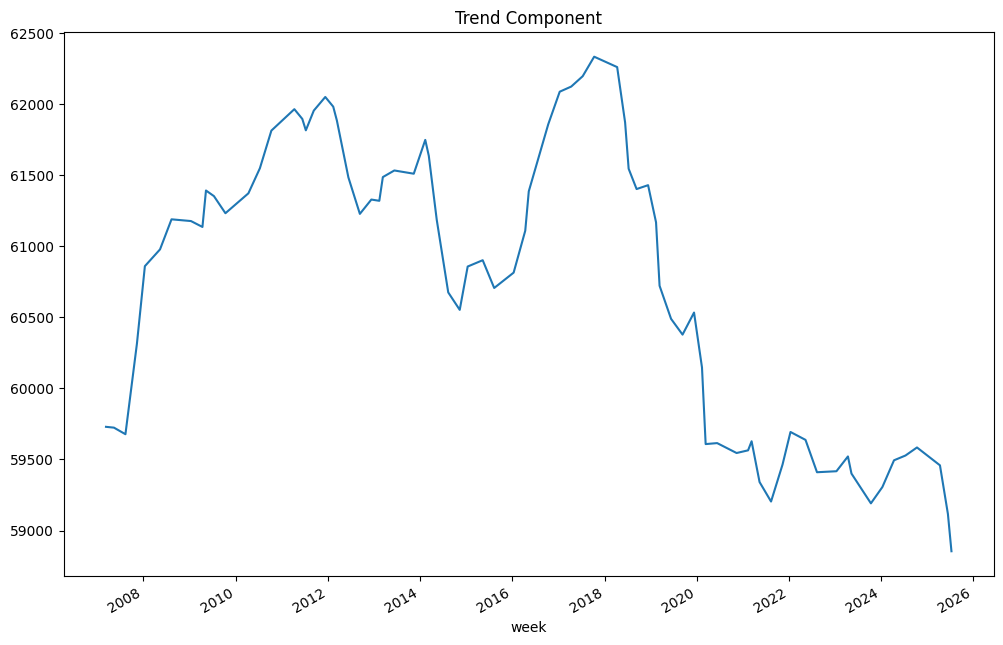

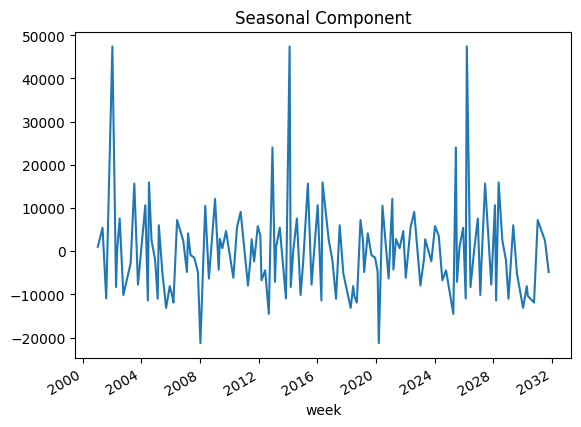

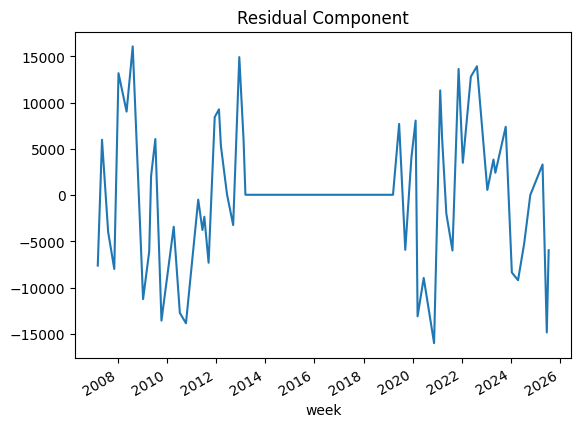

In [11]:
# Seasonality decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

time_series_data = train_data.groupby('week')['units_sold'].sum()
decompose_result = seasonal_decompose(time_series_data, model='additive', period=52)

plt.figure(figsize=(12, 8))
decompose_result.trend.plot(title="Trend Component")
plt.show()

decompose_result.seasonal.plot(title="Seasonal Component")
plt.show()

decompose_result.resid.plot(title="Residual Component")
plt.show()

1. Trend Component (Top Plot)
The trend shows a general increase in sales from 2008 to around 2018, followed by a sharp decline after 2019.
The peak occurs between 2017-2019, suggesting a period of high demand, possibly due to market growth, promotions, or external factors.
A downward trend post-2019 indicates a decline in sales, which could be due to economic conditions, competition, or product saturation.
2. Seasonal Component (Middle Plot)
The seasonal pattern shows recurring fluctuations within each period (52 weeks), indicating strong seasonality.
There are spikes at regular intervals, suggesting that sales peak at certain times of the year, likely due to seasonal demand (e.g., holidays, special promotions).
Some variations in seasonal magnitude suggest that while seasonality is present, its intensity may vary across years.
3. Residual Component (Bottom Plot)
The residuals capture random noise after removing trend and seasonality.
High fluctuations in the residuals suggest that some variations in sales are not fully explained by the trend or seasonality.
The presence of missing or flat values in certain periods may indicate data gaps or imputation errors.
Toward the later years, residuals appear more spread out, implying increasing unpredictability in demand.


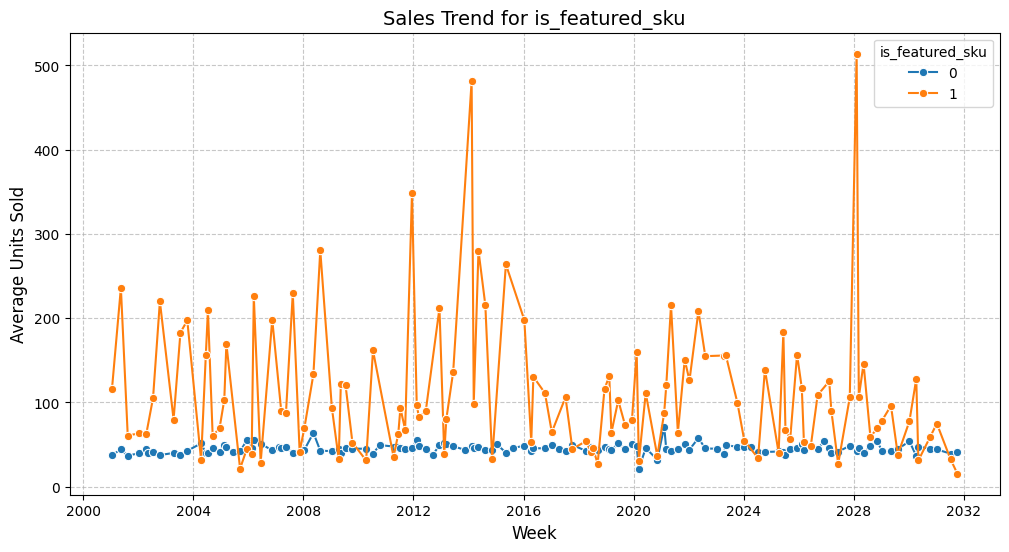

In [12]:
# Aggregate sales data for is_featured_sku
featured_sales = train_data.groupby(['week', 'is_featured_sku'])['units_sold'].mean().reset_index()

# Plot sales trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=featured_sales, x='week', y='units_sold', hue='is_featured_sku', marker='o')
plt.title('Sales Trend for is_featured_sku', fontsize=14)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Average Units Sold', fontsize=12)
plt.legend(title='is_featured_sku')
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()


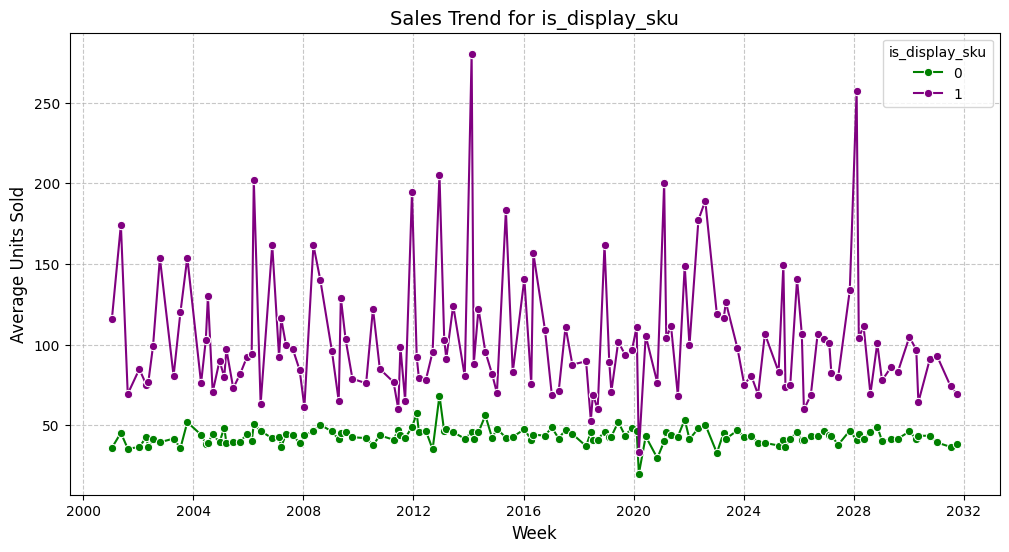

In [13]:
# Aggregate sales data for is_display_sku
display_sales = train_data.groupby(['week', 'is_display_sku'])['units_sold'].mean().reset_index()

# Plot sales trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=display_sales, x='week', y='units_sold', hue='is_display_sku', palette=['green', 'purple'], marker='o')
plt.title('Sales Trend for is_display_sku', fontsize=14)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Average Units Sold', fontsize=12)
plt.legend(title='is_display_sku')
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()


## 3. Data Preprocessing

In [14]:
# Generate time-based features
train_data['year'] = train_data['week'].dt.year

In [15]:
# Add cyclic time features
train_data['sin_week'] = np.sin(2 * np.pi * train_data['week_num'] / 52)
train_data['cos_week'] = np.cos(2 * np.pi * train_data['week_num'] / 52)

In [16]:

# Add price difference feature
train_data['price_diff'] = train_data['base_price'] - train_data['total_price']


In [17]:

# Initialize the LabelEncoder
label_encoder_store = LabelEncoder()
label_encoder_sku = LabelEncoder()

# Label encode the 'store_id' and 'sku_id' columns
train_data['store_id_encoded'] = label_encoder_store.fit_transform(train_data['store_id'])
train_data['sku_id_encoded'] = label_encoder_sku.fit_transform(train_data['sku_id'])

# Include binary features 'is_featured_sku' and 'is_display_sku'
train_data['is_featured_sku'] = train_data['is_featured_sku'].astype(int)
train_data['is_display_sku'] = train_data['is_display_sku'].astype(int)

In [18]:
train_data.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,competitor_price,week_num,year,sin_week,cos_week,price_diff,store_id_encoded,sku_id_encoded
0,1,2017-01-11,8091,216418,99.0375,111.8625,0,0,20,112.256913,2,2017,0.239316,0.970942,12.825,3,1
1,2,2017-01-11,8091,216419,99.0375,99.0375,0,0,28,107.566026,2,2017,0.239316,0.970942,0.000,3,2
2,3,2017-01-11,8091,216425,133.9500,133.9500,0,0,19,146.202998,2,2017,0.239316,0.970942,0.000,3,3
3,4,2017-01-11,8091,216233,133.9500,133.9500,0,0,44,124.354634,2,2017,0.239316,0.970942,0.000,3,0
4,5,2017-01-11,8091,217390,141.0750,141.0750,0,0,52,137.293288,2,2017,0.239316,0.970942,0.000,3,5


## 4. Demand Forecasting with XGBoost

### 4.1: Prepare Data for Forecasting


In [19]:
# Prepare features and target for modeling
features = [
    'store_id', 'sku_id', 'sin_week', 'cos_week', 
    'week_num', 'base_price', 'price_diff', 
    'is_featured_sku', 'is_display_sku'
]
X = train_data[features]
y = train_data['units_sold'] 

# Split the data first (before standardization)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)




In [20]:
# Separate continuous and categorical features
continuous_features = ['sin_week', 'cos_week', 'week_num', 'base_price', 'price_diff']
X_train_continuous = X_train[continuous_features]
X_val_continuous = X_val[continuous_features]

# Step 1: Preserve original base_price in both train and validation sets (before scaling)
X_train['base_price_org'] = X_train['base_price']
X_val['base_price_org'] = X_val['base_price']


In [33]:
# Step 2: Standardize only the continuous features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_continuous_scaled = scaler.fit_transform(X_train_continuous)
X_val_continuous_scaled = scaler.transform(X_val_continuous)

# Step 3: Replace the scaled features back into the train and validation sets
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()

X_train_scaled[continuous_features] = X_train_continuous_scaled
X_val_scaled[continuous_features] = X_val_continuous_scaled

X_train_scaled.drop(columns='base_price_org',inplace=True)
X_val_scaled.drop(columns='base_price_org',inplace=True)

# Check the final dataset
X_train_scaled.columns, X_val_scaled.columns


(Index(['store_id', 'sku_id', 'sin_week', 'cos_week', 'week_num', 'base_price',
        'price_diff', 'is_featured_sku', 'is_display_sku'],
       dtype='object'),
 Index(['store_id', 'sku_id', 'sin_week', 'cos_week', 'week_num', 'base_price',
        'price_diff', 'is_featured_sku', 'is_display_sku'],
       dtype='object'))

In [35]:

X_train_scaled.head()

,store_id,sku_id,sin_week,cos_week,week_num,base_price,price_diff,is_featured_sku,is_display_sku
144063,9700,219009,0.175175,-1.338417,0.038464,0.093113,0.633560,0,0
20252,9425,216419,0.906330,-0.903379,-0.305664,-1.219166,-0.404714,0,0
29262,9112,219009,-0.512092,-1.338417,0.313766,0.048084,-0.404714,0,0
73300,9281,216418,1.225719,-0.304417,-0.580966,-1.206300,-0.404714,0,0
83910,9532,398721,0.340719,-1.287644,-0.030362,2.260946,-0.404714,0,0


### 4.2: Training Models - RandomizedSearchCV

RandomizedSearchCV is a technique used to tune hyperparameters for machine learning models. Unlike GridSearchCV, which exhaustively searches through all possible hyperparameter combinations, RandomizedSearchCV randomly samples from the provided hyperparameter space. This method is computationally more efficient, especially when the hyperparameter grid is large. RandomizedSearchCV also performs cross-validation, which helps evaluate the model’s performance on different subsets of the training data, preventing overfitting.


In this section, we train three different models:

- RandomForestRegressor
- XGBRegressor
- LGBMRegressor

**Hyperparameters Tuned:**

Each model has its own set of hyperparameters, such as:

- Random Forest:

  - n_estimators: The number of decision trees in the forest. More trees generally improve accuracy but increase computation time.

  - max_depth: The maximum depth of the trees. Deeper trees can capture more complexity but might lead to overfitting.

  - min_samples_split: The minimum number of samples required to split an internal node. Higher values prevent the model from overfitting.

  - min_samples_leaf: The minimum number of samples required to be at a leaf node. Larger values help prevent the model from fitting too closely to the training data.

  - max_features: The number of features to consider when looking for the best split. This controls the diversity of the trees and helps prevent overfitting.

- XGBoost
  
  - learning_rate: Determines the weight of each tree. Lower values (e.g., 0.01) make the model more conservative and reduce overfitting, but may require more trees.

  - n_estimators: The number of trees in the model. More trees can increase model accuracy but also the risk of overfitting.

  - max_depth: The maximum depth of each tree. Deeper trees can capture more complexity but can also overfit the data.

  - subsample: The fraction of the training data to use for each tree. Values less than 1 can help regularize the model by preventing overfitting.

  - colsample_bytree: The fraction of features to use for each tree. This helps prevent the model from relying too much on any single feature and overfitting.

- LightGBM

  - learning_rate: Similar to XGBoost, it controls how much each tree contributes to the final prediction.

  - n_estimators: The number of trees. Like in XGBoost, more trees can help improve accuracy, but can also lead to overfitting.

  - max_depth: The maximum depth of trees. Deeper trees can model more complex relationships but may overfit.

  - subsample: Fraction of the training data used to train each tree. It introduces randomness and helps with regularization.

  - colsample_bytree: Fraction of features used in each tree, which helps prevent the model from overfitting to individual features

In [36]:
# Define more extensive hyperparameter grids with regularization
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],  # more depth flexibility
    'min_samples_split': [2, 5, 10],  # Regularization: Increasing min_samples_split helps control overfitting
    'min_samples_leaf': [1, 2, 4],  # Regularization: Increasing min_samples_leaf helps control overfitting
    'max_features': [ 'sqrt', 'log2', None],  # Regularization: Limit features to prevent overfitting
    'bootstrap': [True, False]  # Control the use of bootstrap samples for Random Forest
}

xgb_params = {
    'n_estimators': [100, 200, 300],  #range of estimators
    'learning_rate': [0.01, 0.05, 0.1],  #learning rates
    'max_depth': [3, 6, 10],  # deeper trees for more complexity
    'subsample': [0.7, 0.8, 1.0],  # Regularization: Fraction of samples used for training
    'colsample_bytree': [0.7, 0.8, 1.0],  # Regularization: Fraction of features used per tree
    'alpha': [0, 0.1, 0.5],  # L1 regularization (Lasso)
    'lambda': [1, 1.5, 2],  # L2 regularization (Ridge)
}

lgbm_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 10, -1],  # Allow deeper trees for more complexity
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'lambda_l2': [0, 0.1, 0.5],  # L2 regularization
    'lambda_l1': [0, 0.1, 0.5],  # L1 regularization
}

# Reduce n_iter to speed up the process
n_iter = 15  # Fewer iterations for quicker search


### Random Forest
Random Forest is an ensemble learning method that builds multiple decision trees and combines their predictions. Each tree is trained on a random subset of the data, and predictions are made by averaging the outputs of all trees. This approach reduces overfitting by relying on the majority vote of many trees rather than just one. Random Forest is robust and works well with large datasets, capturing complex relationships in the data.

In [37]:
# Random Forest
print("Running RandomizedSearchCV for RandomForest...")
rf_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=rf_params,
    n_iter=n_iter,  # Reduced iterations
    scoring='neg_mean_absolute_error',
    cv=3,  # Reduced to 3-fold CV
    verbose=1,
    random_state=42,
    n_jobs=-1
)
rf_search.fit(X_train_scaled, y_train)
print("RandomForest Best MAE:", -rf_search.best_score_)
print("RandomForest Best Params:", rf_search.best_params_)

Running RandomizedSearchCV for RandomForest...
Fitting 3 folds for each of 15 candidates, totalling 45 fits


C:\Users\asira\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomForest Best MAE: 15.157830301090874
RandomForest Best Params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': None, 'bootstrap': True}


In [38]:
#import sklearn
#print(sklearn.__version__)
#if version>=1.5.2:
#!pip install scikit-learn==1.5.2

### XGBoost
XGBoost stands for Extreme Gradient Boosting, which is a powerful, efficient, and scalable model. It builds trees sequentially, with each new tree trying to correct the errors made by the previous ones. It is a type of boosting, where weak learners (small decision trees) are combined to form a strong model. XGBoost uses techniques like regularization to prevent overfitting and improve the model’s generalization ability. The model is highly efficient due to optimization tricks such as parallelization and tree pruning.

In [39]:
# Initialize the XGBRegressor
xgb_model = XGBRegressor(random_state=42)

# Initialize RandomizedSearchCV
xgb_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_params,
    n_iter=10,  # Number of parameter settings to sample
    scoring='neg_mean_absolute_error',  # Use MAE as scoring metric
    cv=3,  # Number of cross-validation folds
    verbose=1,  # Verbosity level
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Train-test split (assuming you have your data as X and y)
# Ensure X_train_scaled, X_test, y_train, y_test are pre-defined
xgb_search.fit(X_train_scaled, y_train)

# results
print("XGBoost Best MAE:", -xgb_search.best_score_)
print("XGBoost Best Params:", xgb_search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
XGBoost Best MAE: 13.282712425832221
XGBoost Best Params: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.1, 'lambda': 1, 'colsample_bytree': 1.0, 'alpha': 0.1}


### LightGBM
LightGBM is a gradient boosting algorithm that is optimized for speed and memory efficiency, making it faster than traditional boosting algorithms like XGBoost. It builds trees in a histogram-based manner, grouping similar data points together to improve training speed and reduce memory usage. LightGBM is especially effective when dealing with large datasets and is capable of handling categorical features directly. It is a good choice when both speed and accuracy are crucial.

In [40]:
# LightGBM
print("Running RandomizedSearchCV for LightGBM...")
lgbm_search = RandomizedSearchCV(
    estimator=LGBMRegressor(random_state=42),
    param_distributions=lgbm_params,
    n_iter=n_iter,  # Reduced iterations
    scoring='neg_mean_absolute_error',
    cv=3,  # Reduced to 3-fold CV
    verbose=1,
    random_state=42,
    n_jobs=-1
)
lgbm_search.fit(X_train_scaled, y_train)
print("LightGBM Best MAE:", -lgbm_search.best_score_)
print("LightGBM Best Params:", lgbm_search.best_params_)

Running RandomizedSearchCV for LightGBM...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 668
[LightGBM] [Info] Number of data points in the train set: 120119, number of used features: 9
[LightGBM] [Info] Start training from score 51.858765
LightGBM Best MAE: 15.186425858920122
LightGBM Best Params: {'subsample': 0.8, 'n_es

After training the models with optimal hyperparameters, we generate predictions for the target variable (e.g., units_sold) using the trained models. These predictions are then evaluated using three common regression metrics:

1. R-squared (R²):
What it tells you: Measures the proportion of variance in the target variable explained by the model.
Interpretation: Values range from 0 to 1. Higher is better; a value of 1 indicates perfect prediction.
2. Mean Absolute Error (MAE):
What it tells you: The average absolute difference between predicted and actual values.
Interpretation: Smaller values indicate better performance, easy to interpret in terms of units of the target variable.

In [41]:
# Evaluate on validation set
print("\nValidation Results:")
models = {
    'RandomForest': rf_search.best_estimator_,
    'XGBoost': xgb_search.best_estimator_,
    'LightGBM': lgbm_search.best_estimator_
}

for name, model in models.items():
    val_predictions = model.predict(X_val_scaled)
    mae = mean_absolute_error(y_val, val_predictions)
    r2 = r2_score(y_val, val_predictions)
    print(f"{name} Validation Results:")
    print(f"  MAE: {mae:.4f}")
    print(f"  R-squared (R²): {r2:.4f}")


Validation Results:
RandomForest Validation Results:
  MAE: 14.2583
  R-squared (R²): 0.7659
XGBoost Validation Results:
  MAE: 12.4736
  R-squared (R²): 0.8355
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
LightGBM Validation Results:
  MAE: 14.7385
  R-squared (R²): 0.8112


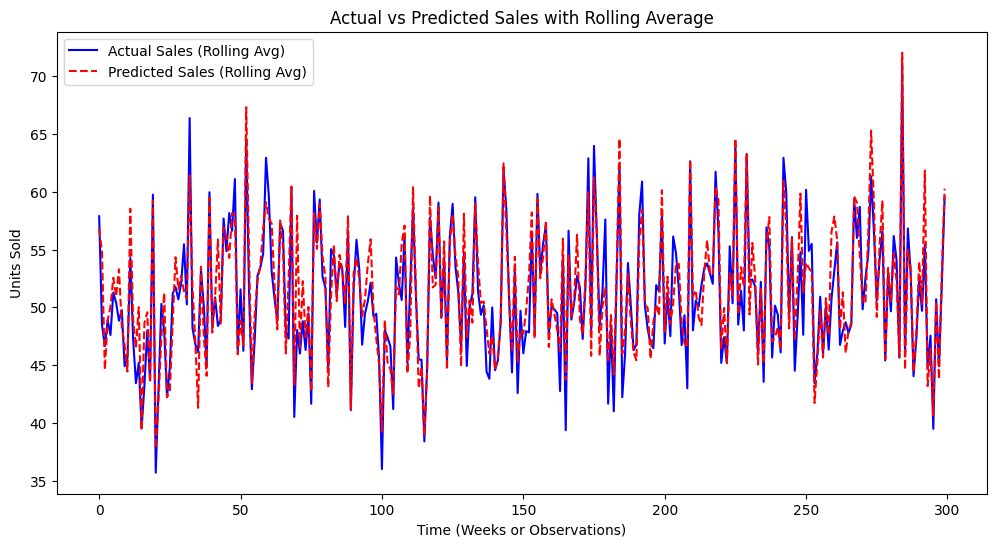

In [44]:
rolling_window = 100  # Choose a window size
y_val_rolling = y_val.values[:len(y_val) - len(y_val) % rolling_window].reshape(-1, rolling_window).mean(axis=1)
y_pred_rolling = xgb_search.best_estimator_.predict(X_val_scaled)[:len(y_val) - len(y_val) % rolling_window].reshape(-1, rolling_window).mean(axis=1)

plt.figure(figsize=(12,6))
plt.plot(range(len(y_val_rolling)), y_val_rolling, label="Actual Sales (Rolling Avg)", linestyle="-", color='blue')
plt.plot(range(len(y_pred_rolling)), y_pred_rolling, label="Predicted Sales (Rolling Avg)", linestyle="--", color='red')
plt.xlabel("Time (Weeks or Observations)")
plt.ylabel("Units Sold")
plt.title("Actual vs Predicted Sales with Rolling Average")
plt.legend()
plt.show()


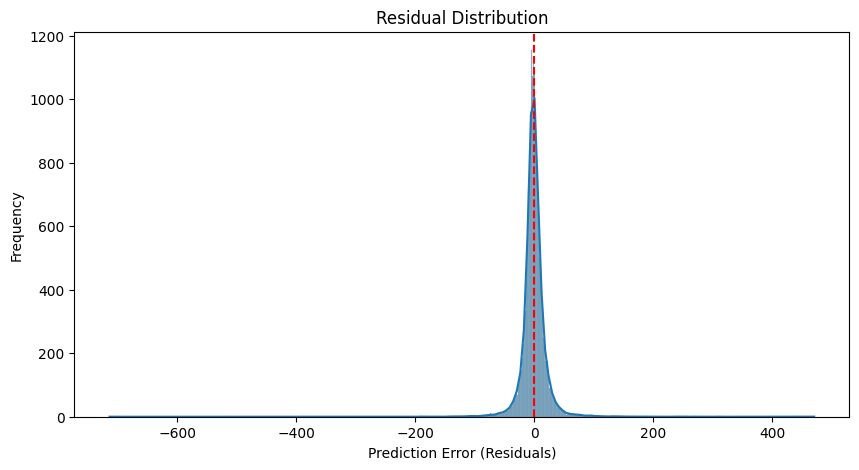

In [46]:
import seaborn as sns

residuals = y_val - xgb_search.best_estimator_.predict(X_val_scaled)

plt.figure(figsize=(10,5))
sns.histplot(residuals, kde=True)
plt.axvline(x=0, color='r', linestyle='--')
plt.title("Residual Distribution")
plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Frequency")
plt.show()


Residuals are normally distributed around zero, the model makes unbiased predictions.

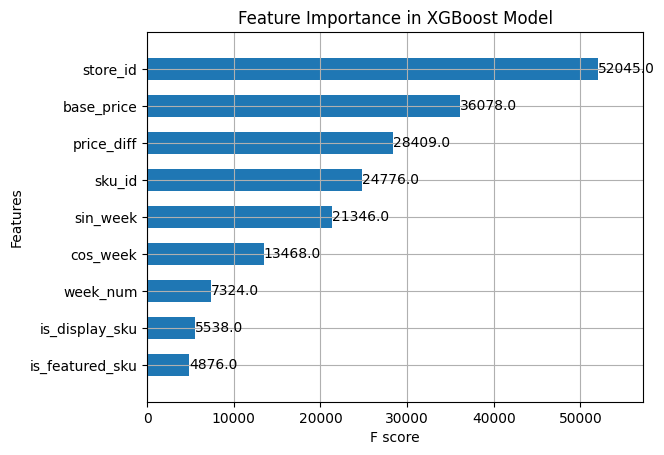

In [47]:
import xgboost as xgb

# Assuming xgb_search.best_estimator_ is your fitted model
booster = xgb_search.best_estimator_.get_booster()

# Set feature names manually
booster.feature_names = ['store_id', 'sku_id', 'sin_week', 'cos_week', 'week_num', 'base_price',
        'price_diff', 'is_featured_sku', 'is_display_sku']

# Now plot the feature importance
xgb.plot_importance(booster, importance_type="weight", height=0.6)
plt.title("Feature Importance in XGBoost Model")
plt.show()

## 4. Price Optimization Using Linear Programming

- Defining an objective function to maximize profit: 
Profit=(Price−Cost)×Quantity.

- Setting price bounds based on competitor prices.
- To find the optimal price that maximizes profit while staying competitive and covering costs.

In [50]:
# Predict demand using the entire dataset
X_full = full_data[features]  # All data (train + validation) for price optimization
X_full_scaled = scaler.transform(X_full[continuous_features])  # Apply scaling (if used)

# Predict demand using the trained model
predicted_demand_full = xgb_search.best_estimator_.predict(X_full_scaled)


        store_id  sku_id  is_featured_sku  is_display_sku  sin_week  cos_week  \
144782      9132  223153                0               0  0.239316 -0.970942   
117         8222  378934                0               0  0.239316  0.970942   
77408       8095  223153                1               1  0.748511 -0.663123   
62193       9809  245338                0               0  0.239316  0.970942   
143901      9479  217777                0               0  0.239316 -0.970942   

        week_num  base_price  price_diff  predicted_demand  
144782        24    212.3250       0.000         44.826057  
117            2    205.9125       0.000         12.984386  
77408         19    227.2875      86.925        394.374878  
62193          2    498.0375       0.000         15.524729  
143901        24    237.9750       0.000         13.497330  


In [ ]:

# Now you can use the denormalized base price in optimization


In [ ]:
# Define decision variables for optimized prices (price for each SKU)
price_vars = {sku: LpVariable(f"price_{sku}", lowBound=5, upBound=100, cat='Continuous') for sku in df.sku_id.unique()}

# Check the decision variables
price_vars


In [ ]:
# Initialize the optimization model
model = LpProblem("Price_Optimization", LpMaximize)

# Objective: Maximize total revenue (Revenue = Price * Demand)
model += sum(price_vars[sku] * df[df.sku_id == sku]["predicted_demand"].values[0] for sku in df.sku_id.unique())

# Check the objective function
model.objective

In [ ]:
# Add price constraints based on base price
for sku in df.sku_id.unique():
    base_price = df[df.sku_id == sku]["base_price"].values[0]
    
    # Price should not be too far from base price (e.g., 80% to 120% of base price)
    model += price_vars[sku] >= 0.8 * base_price  # Price at least 80% of base price
    model += price_vars[sku] <= 1.2 * base_price  # Price at most 120% of base price

# Check the constraints
for constraint in model.constraints.values():
    print(constraint)


In [ ]:
# Solve the optimization problem
model.solve()

In [ ]:
print(df[['sku_id', 'base_price']].head())


In [ ]:
# Check the status of the optimization result
print(f"Status: {model.status}")


In [ ]:
# Extract the optimized prices for each SKU
optimized_prices = {sku: price_vars[sku].varValue for sku in df.sku_id.unique()}

# Convert the optimized prices to a DataFrame for easy display
optimized_prices_df = pd.DataFrame.from_dict(optimized_prices, orient='index', columns=['optimized_price'])

# Merge the optimized prices into the original DataFrame
optimized_prices_df.index.name = 'sku_id'
df_optimized = df.merge(optimized_prices_df, left_on='sku_id', right_index=True, how='left')

# Display the original data with optimized prices
print(df_optimized[['sku_id', 'base_price', 'predicted_demand', 'optimized_price']].head())

### 4.1: Define the Problem

In [ ]:
# Add cost and competitor pricing data
latest_data['cost'] = df.groupby('product_id')['freight_price'].mean().values  # Average cost
latest_data['min_price'] = df.groupby('product_id')['comp_1'].mean().values  # Competitor price
latest_data['max_price'] = latest_data['min_price'] + 10  # Business rule: Max price is +10

# Objective: Maximize profit = (price - cost) × quantity
profit_coefficients = -(latest_data['forecast_qty'] * (latest_data['lag_1'] - latest_data['cost']))

# Price bounds: min_price ≤ price ≤ max_price
bounds = [(row['min_price'], row['max_price']) for _, row in latest_data.iterrows()]

### 4.2: Solve the Optimization Problem

In [ ]:
# Solve using Linear Programming
result = linprog(
    c=profit_coefficients,
    bounds=bounds,
    method='highs'
)

# Store optimized prices
latest_data['optimized_price'] = result.x
print(latest_data[['product_id', 'forecast_qty', 'cost', 'optimized_price']])


## 5. Visualization

### 5.1: Forecasted Demand and Optimized Pricing

In [ ]:
# Plot forecasted demand and optimized prices
plt.figure(figsize=(14, 8))
sns.barplot(x='product_id', y='forecast_qty', data=latest_data, color='blue', label='Forecasted Demand')
sns.lineplot(x='product_id', y='optimized_price', data=latest_data, color='red', label='Optimized Price', marker='o')
plt.title('Forecasted Demand and Optimized Pricing')
plt.xlabel('Product ID')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=90)
plt.show()


## 6. Dashboard for Real-Time Interaction

### 6.1: Build a Streamlit App

In [ ]:

# Load processed data
data = pd.read_csv('optimized_data.csv')

st.title('Dynamic Price Optimization')
st.sidebar.header('Select Product')

# Select product
product_id = st.sidebar.selectbox('Product ID', data['product_id'].unique())

# Filter data for the selected product
product_data = data[data['product_id'] == product_id]

st.write(f"### Forecasted Demand for Product {product_id}")
st.dataframe(product_data[['forecast_qty']])

st.write(f"### Optimized Price for Product {product_id}")
st.dataframe(product_data[['optimized_price']])
